In [1]:
## Standard libraries
import os
import json
import math
import numpy as np
import copy

## Imports for plotting
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
import seaborn as sns
sns.set()

## Progress bar
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

<ipython-input-1-eab9a83ee4d9>:13: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


In [2]:
# Path to the folder where the datasets are/should be downloaded (e.g. MNIST)
DATASET_PATH = "../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../saved_models/tutorial4"

# Function for setting the seed
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
set_seed(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Fetching the device that will be used throughout this notebook
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

Using device cuda:0


In [3]:
import urllib.request
from urllib.error import HTTPError
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial4/"
pretrained_files = ["FashionMNIST_Adam.config",   "FashionMNIST_Adam_results.json",   "FashionMNIST_Adam.tar"]
os.makedirs(CHECKPOINT_PATH, exist_ok=True)
for file_name in pretrained_files:
  file_path = os.path.join(CHECKPOINT_PATH, file_name)
  if not os.path.isfile(file_path):
    file_url = base_url + file_name
    print(f"Downloading {file_url}...")
    try:
      urllib.request.urlretrieve(file_url, file_path)
    except HTTPError as e:
      print("Something went wrong!")




In [4]:
from torchvision.datasets import FashionMNIST
from torchvision import transforms

# Transformations applied on each image => first make them a tensor, then normalize them with mean 0 and std 1
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.2861,), (0.3530,))
                               ])

# Loading the training dataset. We need to split it into a training and validation part
train_dataset = FashionMNIST(root=DATASET_PATH, train=True, transform=transform, download=True)
train_set, val_set = torch.utils.data.random_split(train_dataset, [50000, 10000])

# Loading the test set
test_set = FashionMNIST(root=DATASET_PATH, train=False, transform=transform, download=True)

# We define a set of data loaders that we can use for various purposes later.
# Note that for actually training a model, we will use different data loaders
# with a lower batch size.
train_loader = data.DataLoader(train_set, batch_size=1024, shuffle=True, drop_last=False)
val_loader = data.DataLoader(val_set, batch_size=1024, shuffle=False, drop_last=False)
test_loader = data.DataLoader(test_set, batch_size=1024, shuffle=False, drop_last=False)

100%|██████████| 26421880/26421880 [00:02<00:00, 10883084.81it/s]


Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 181497.20it/s]


Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3216712.82it/s]


Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 22848970.36it/s]

Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



In [5]:
print("Mean", (train_dataset.data.float() / 255.0).mean().item())
print("Std", (train_dataset.data.float() / 255.0).std().item())

Mean 0.2860405743122101
Std 0.3530242443084717


In [6]:
imgs, _ = next(iter(train_loader))
print(f"Mean: {imgs.mean().item():5.3f}")
print(f"Standard deviation: {imgs.std().item():5.3f}")
print(f"Maximum: {imgs.max().item():5.3f}")
print(f"Minimum: {imgs.min().item():5.3f}")

Mean: 0.020
Standard deviation: 1.011
Maximum: 2.022
Minimum: -0.810


In [7]:
class BaseNetwork(nn.Module):
  def __init__(self, act_fn, input_size = 784, num_classes = 10, hidden_sizes = [512, 256, 256, 128]):
    super().__init__()
    layers =[]
    layer_sizes = [input_size] + hidden_sizes
    for layer_index in range(1, len(layer_sizes)):
      layers += [nn.Linear(layer_sizes[layer_index-1],layer_sizes[layer_index]), act_fn]
    layers += [nn.Linear(layer_sizes[-1], num_classes)]
    self.layers = nn.ModuleList(layers)
    self.config = {"act_fn":act_fn.__class__.__name__, "input_size":input_size, "num_classes":num_classes, "hidden_size":hidden_sizes}

  def forward(self, x):
    x = x.view(x.size(0), -1)
    for l in self.layers:
      x = l(x)
    return x

In [8]:
class Identity(nn.Module):
    def forward(self, x):
        return x

act_fn_by_name = {
    "relu": nn.ReLU,
    "identity": Identity
}

In [9]:
def plot_dists(val_dict, color = "C0", xlabel = None, stat = "count", use_kde = True):
    columns = len(val_dict)
    fig, ax = plt.subplots(1, columns, figsize = (columns * 3, 2.5))
    fig_index = 0
    for key in sorted(val_dict.keys()):
      key_ax = ax[fig_index % columns]
      sns.histplot(val_dict[key], ax = key_ax, color = color, bins = 50, stat = stat, kde = use_kde and val_dict[key].max()-val_dict[key].min()>1e-8)
      key_ax.set_title(f"{key}" + (r'(%i $\to$ %i)' % (val_dict[key].shape[0], val_dict[key].shape[1]) if len(val_dict[key].shape) > 1 else ""))
      if xlabel is not None:
        key_ax.set_label(xlabel)
      fig_index += 1
    fig.subplots_adjust(wspace = 0.4)
    return fig



def visualize_weight_distribution(model, color = "C0"):
    weights = {}
    for name, param in model.named_parameters():
      if name.endswitch('.bias'):
        continue
      key_name = f"Layer{name.split('.')[1]}"
      weights[key_name] = param.detach().view(-1).cpu().numpy()

    fig = plot_dists(weights, color = color, xlabel = "Weight vals")
    fig.suptitle("Weight distribution", fontsize = 14, y = 1.05)
    plt.show()
    plt.close()


def visualize_gradients(model, color = "C0", print_varience = False):
    model.eval()
    small_loader = data.DataLoader(train_set, batch_size = 1024, shuffle = False)
    imgs, labels = next(iter(small_loader))
    imgs, labels = imgs.to(device) , labels.to(device)

    model.zero_grad()
    preds = model(imgs)
    loss = F.cross_entropy(preds, labels)
    loss.backward()
    grads = {name:params.grad.view(-1).cpu().clone().numpy() for name, params in model.named_parameters() if "weight" in name}
    model.zero_grad()

    fig = plot_dists(grads, color = color, xlabel = "Grad magnitude")
    fig.suptitle("Grad Distribution", fontsize = 14, y = 1.05)
    plt.show()
    plt.close()

    if print_varience:
      for key in sorted(grads.keys()):
        print(f"{key} - Varience:{np.var(grads[key])}")



def visualize_activations(model, color = "C0", print_varience = False):
  model.eval()
  small_loader = data.DataLoader(train_set, batch_size = 1024, shuffle = False)
  imgs, labels = next(iter(small_loader))
  imgs, labels = imgs.to(device), labels.to(device)

  feats = imgs.view(imgs.shape[0],-1)
  activations = {}
  with torch.no_grad():
    for layer_index, layer in enumerate(model.layers):
      feats = layer(feats)
      if isinstance(layer, nn.Linear):
        activations[f"Layer {layer_index}"] = feats.view(-1).detach().cpu().numpy()

  fig = plot_dists(activations, color = color, stat = "density", xlabel = "Activation Vals")
  fig.suptitle("Activation Distibution", fontsize = 14, y = 1.05)
  plt.show()
  plt.close()

  if print_varience:
    for key in sorted(activations.keys()):
      print(f"{key} - Varience:{np.var(activations[key])}")


In [10]:
model = BaseNetwork(act_fn=Identity()).to(device)

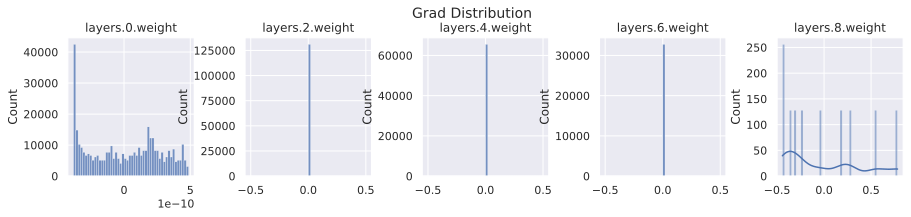

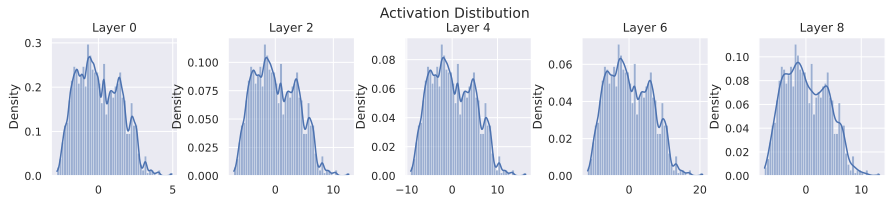

Layer 0 - Varience:2.0582759380340576
Layer 2 - Varience:13.489116668701172
Layer 4 - Varience:22.100570678710938
Layer 6 - Varience:36.209571838378906
Layer 8 - Varience:14.831440925598145


In [12]:
def cost_init(model, c = 0.0):
  for name, param in model.named_parameters():
    param.data.fill_(c)

cost_init(model, c=0.005)
visualize_gradients(model)
visualize_activations(model, print_varience=True)

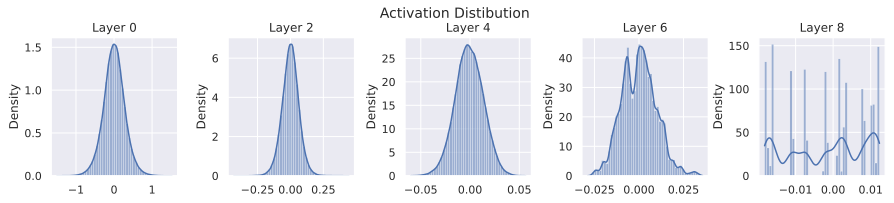

Layer 0 - Varience:0.07794515788555145
Layer 2 - Varience:0.004074736498296261
Layer 4 - Varience:0.0002034862118307501
Layer 6 - Varience:9.358522220281884e-05
Layer 8 - Varience:0.00010496507456991822


In [13]:
def var_init(model, std = 0.01):
  for name, param in model.named_parameters():
    param.data.normal_(std = std)

var_init(model, std = 0.01)
visualize_activations(model, print_varience=True)

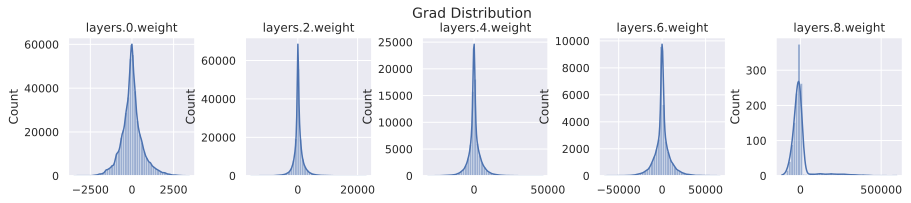

layers.0.weight - Varience:418574.96875
layers.2.weight - Varience:2871131.25
layers.4.weight - Varience:20178542.0
layers.6.weight - Varience:93316776.0
layers.8.weight - Varience:5299339776.0


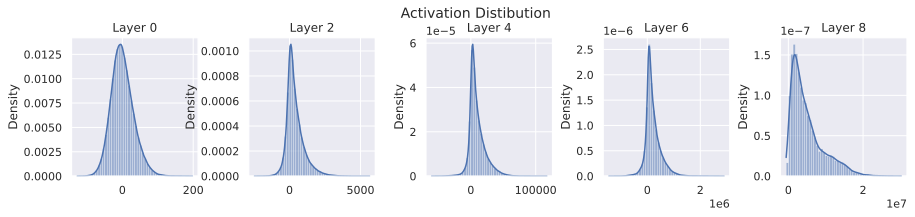

Layer 0 - Varience:997.6196899414062
Layer 2 - Varience:374108.3125
Layer 4 - Varience:149290480.0
Layer 6 - Varience:79239585792.0
Layer 8 - Varience:18950012272640.0


In [14]:
def kaiming_init(model):
  for name, param in model.named_parameters():
    if name.endswith(".bias"):
      param.data.fill_(0)
    elif name.startswith("layer.0"):
      param.data.normal_(0, 1/math.sqrt(param.shape[1]))
    else:
      param.data.normal_(math.sqrt(2)/math.sqrt(param.shape[1]))

model = BaseNetwork(act_fn = nn.ReLU()).to(device)
kaiming_init(model)
visualize_gradients(model, print_varience=True)
visualize_activations(model, print_varience=True)


In [29]:
def _get_config_file(model_path , model_name):
  return os.path.join(model_path, model_name + ".config")

def _get_model_file(model_path, model_name):
  return os.path.join(model_path, model_name + ".tar")

def _get_result_file(model_path, model_name):
  return os.path.join(model_path, model_name + "_results.json")

def load_model(model_path, model_name, net = None):
  config_file, model_file = _get_config_file(model_path, model_name), _get_model_file(model_path, model_name)
  assert os.path.isfile(config_file), f"Couldn't find the config file \"{config_file}\". Are you sure this is the correct path and you have your model config stored here?"
  assert os.path.isfile(model_file),f"Couldn't find the model file \"{model_file}\". Are you sure this is the correct path and you have your model stored here?"
  with open(config_file, "r") as f:
    config_dict = json.load(f)
  if net is None:
    act_fn_name = config_dict["fn_name"].pop("name").lower()
    assert act_fn_name in act_fn_by_name, f"Unknown activation function \"{act_fn_name}\". Please add it to the \"act_fn_by_name\" dict."
    act_fn = act_fn_by_name[act_fn_name]()
    net  = BaseNetwork(act_fn = act_fn, **config_dict)
  net.load_state_dict(torch.load(model_file))
  return model_file

def save_model(model, model_path, model_name):
  config_dict = model.config
  os.makedirs(model_path, exist_oke = True)
  config_file, model_file = _get_config_file(model_path, model_name), _get_model_file(model_path, model_name)
  with open(config_file, "w") as f:
    json.dump(config_dict, f)
  torch.save(model.state_dict, model_file)

def train_model(net, model_name, optim_func, max_epochs = 50, batch_size = 256, overwrite = False):
  file_exists = os.path.isfile(_get_model_file(CHECKPOINT_PATH, model_name))
  if file_exists and not overwrite:
    print(f"Model file of \"{model_name}\"is already exist. Skipping training ...")
    with open(_get_result_file(CHECKPOINT_PATH, model_name), "r") as f :
      results = json.load(f)
  else:
    if file_exist:
      print("Model file is exist, but will be overwritten")

      optimizer = optim_func(net.parameter())
      loss_model = nn.CrossEntropyLoss()
      train_loader_local = data.Dataloader(train_set, batch_size = batch_size, shuffle = True, drop_last = True, pin_memory = True)

      results = None
      val_scores = []
      train_losses, train_scores = [], []
      best_val_epoch = -1
      for epoch in range(max_epochs):
        net.train
        true_preds, count = 0., 0
        t = tqdm(train_loader_local, leave = False)
        for imgs, labels in t:
          imgs, labels = imgs.to(device), labels.to(device)
          optimizer.zero_grad()
          preds = net(imgs)
          loss = loss_model(preds, labels)
          loss.backward()
          optimizer.step()
          true_preds += (preds.armax(dim=-1) == labels).sum().item()
          count += labels.shape[0]
          t.set_description(f"Epoch {epoch+1}: loss = {loss.item():4.2f}")
          train_losses.append(loss.item())
        train_acc = true_preds/count
        train_scores.append(train_acc)

        val_acc = test_model(net, val_loader)
        val_scores.append(val_acc)
        print(f"Epoch {epoch+1:2d} training accuracy: {train_acc*100.0:05.2f}%, validation accuracy:{val_acc*100.0:05.2f}%")

        if len(val_scores) == 1 or val_acc > val_scores[best_val_epoch]:
          print("\t (New best performance, saving model, ...)")
          save_model(net, CHECKPOINT_PATH, model_name)
          best_val_epoch = epoch

  if results is None:
    load_model(CHECKPOINT_PATH, model_name, net = net)
    test_acc = test_model(net, test_loader)
    results = {"test_acc":test_acc, "val_scores":val_scores, "train_scores":train_scores, "train_scores":train_scores}
    with (_get_result_file(CHECKPOINT_PATH, model_name), "w") as f:
      json.dump(results, f)


  sns.set()
  plt.plot([i for i in range(1, len(results["train_scores"])+1)], results["train_scores"], label = "Train")
  plt.plot([i for i in range(1, len(results["val_scores"])+1)], results["val_scores"], label = "Val")
  plt.xlabel("Epoch")
  plt.ylabel("Validation Accuracy")
  plt.ylim(min(results["val_scores"]), max(results["val_scores"])*1.01)
  plt.title(f"Valiation performance of {model_name}")
  plt.legend()
  plt.show()
  plt.close()

  print((f"Test accuracy: {results['test_acc']*100.0:4.2f}%").center(50, "=")+"\n")
  return results

def test_model(net, data_loader):
    net.eval()
    true_preds, count = 0., 0
    for imgs, labels in data_loader:
      imgs, labels = imgs.to(device), labels.to(device)
      with torch.no_grad():
        preds = net(imgs).argmax(dim=-1)
        true_preds += (preds == labels).sum().item()
        count += labels.shape[0]
    test_acc = true_preds/count
    return test_acc


In [21]:
class OptimizerTemplate:
  def __init__(self, params, lr):
    self.params = list(params)
    self.lr = lr

  def zero_grad():
    for p in self.params:
      if p.grad is not None:
        p.grad.detach_()
        p.grad.zero_()

  @torch.no_grad()
  def step(self):
    for p in self.params:
      if p.grad is None:
        continue
      self.update_param(p)

  def update_param(self, p):
    raise NotImplementedError


In [22]:
class Adam(OptimizerTemplate):
  def __init__(self, params, lr, beta1=0.9, beta2=0.999, eps=1e-8):
    super().__init__(params, lr)
    self.beta1 = beta1
    self.beta2 = beta2
    self.eps = eps
    self.param_step = {p: 0 for p in self.params}
    self.param_momentum = {p: torch.zeros_like(p.data) for p in self.params}
    self.param_2nd_momemtum = {p: torch.zeros_like(p.data) for p in self.params}

  def update_param(self, p):
    self.param_step[p] += 1
    self.param_momentum[p] = (1-self.beta1) * p.grad + self.beta1 * self.param_momentum
    self.param_2nd_momentum[p] = (1-self.beta2) * (p.grad)**2 + self.beta2 * self.param_2nd_momentum

    bias_correction_1 = 1 - self.beta1 ** self.param_step[p]
    bias_correction_2 = 1 - self.beta2 ** self.param_step[p]

    p_2nd_mom = self.param_2nd_momentum[p]/bias_correction_2
    p_mom = self.param_momentum[p]/bias_correction_1
    p_lr = self.lr / (torch.sqrt(p_2nd_mom) + self.eps)
    p_update = -p_lr * p_mom
    p.add_(p_update)

In [24]:
base_model = BaseNetwork(act_fn = nn.ReLU(), hidden_sizes = [512, 256, 256, 128])
kaiming_init(base_model)

Model file of "FashionMNIST_Adam"is already exist. Skipping training ...


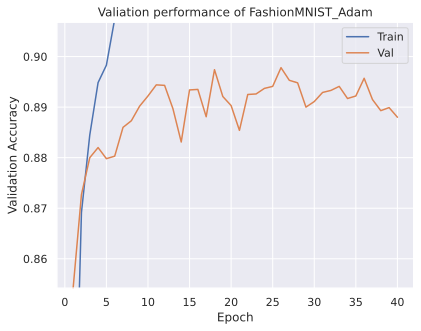

==============Test accuracy: 89.46%===============



In [31]:
Adam_model = copy.deepcopy(base_model).to(device)
Adam_results = train_model(Adam_model, "FashionMNIST_Adam", lambda params: Adam(params, lr = 1e-3), max_epochs = 40, batch_size = 256)